# Topology optimization using torch-fem

## Problem configuration 
The configuration of the problem is defined as a dictionary that is consistent to the format used in [ToPy](https://github.com/williamhunter/topy) for comparison to well established codes.

In [1]:
# The 'classic' 60x20 2d mbb beam, as per Ole Sigmund's 99 line code.
config = {
    "FILT_RAD": 1.5,
    "FXTR_NODE_X": range(1, 22),
    "FXTR_NODE_Y": 1281,
    "LOAD_NODE_Y": 1,
    "LOAD_VALU_Y": -1,
    "NUM_ELEM_X": 60,
    "NUM_ELEM_Y": 20,
    "NUM_ITER": 94,
    "P_FAC": 3.0,
    "VOL_FRAC": 0.5,
}

Using the configuration, we can build the FEM model representing the solution domain.

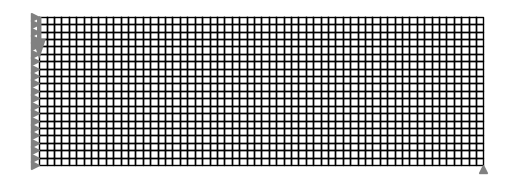

In [2]:
import torch
torch.set_default_dtype(torch.double)
from torchfem import Planar

Nx = config["NUM_ELEM_X"]
Ny = config["NUM_ELEM_Y"]

# Create nodes
n1 = torch.linspace(0.0, Nx, Nx + 1)
n2 = torch.linspace(Ny, 0.0, Ny + 1)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="ij"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for j in range(Ny):
    for i in range(Nx):
        n0 = j + i * (Ny + 1)
        elements.append([n0, n0 + 1, n0 + Ny + 2, n0 + Ny + 1])

# Load at top
forces = torch.zeros_like(nodes)
forces[torch.tensor(config["LOAD_NODE_Y"])-1, 1] = config["LOAD_VALU_Y"]

# Constrained displacement at left end
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[torch.tensor(config["FXTR_NODE_X"])-1, 0] = True
constraints[torch.tensor(config["FXTR_NODE_Y"])-1, 1] = True

# Thickness
thickness = torch.ones(len(elements))

# Material model (plane stress)
E = 100.0
nu = 0.3
C = (E / ((1.0 + nu) * (1.0 - 2.0 * nu))) * torch.tensor(
    [[1.0 - nu, nu, 0.0], [nu, 1.0 - nu, 0.0], [0.0, 0.0, 0.5 - nu]]
)

# Create and plot the domain
model = Planar(nodes, elements, forces, constraints, thickness, C)
model.plot()

## Optimization
We solve the toplogy optimization problem of minimizing compliance for a prescribed volume fraction via optimality conditions. To do so, we first define couple of optimization parameters:

In [3]:
# Initial, minimum, and maximum values of design variables
rho_0 = config["VOL_FRAC"] * torch.ones(len(elements), requires_grad=True)
rho_min = 0.01 * torch.ones_like(rho_0)
rho_max = torch.ones_like(rho_0)

# Volume fraction
V_0 = config["VOL_FRAC"] * Nx * Ny 

# Analytical gradient of the stiffness matrix
k0 = torch.einsum("i,ijk->ijk", 1.0 / model.thickness, model.k())

# Move limit for optimality condition algortihm
move = 0.2

# Precompute filter weights
if config["FILT_RAD"] > 0.0:
    ecenters = torch.stack([torch.mean(nodes[e], dim=0) for e in elements])
    dist = torch.cdist(ecenters, ecenters)
    H = config["FILT_RAD"] - dist
    H[dist > config["FILT_RAD"]] = 0.0

This is the actual optimization using optimality conditions. There are two variants:
- `TORCH_SENS = True` uses automatic differentiation to compute the sensitivities $\frac{\partial C}{\partial \rho_i}$ making use of the torch implementation of FEM. 
- `TORCH_SENS = False` uses the well established analytical solution for the sensitivities $$\frac{\partial C}{\partial \rho_i} = -p \rho_i^{p-1} \mathbf{u} \cdot \mathbf{k_0} \cdot \mathbf{u}.$$

In this case, automatic differentiation is approximately 30-50% slower, but it eliminates the need to compute sensitivities. This might be useful, if analytical solutions are not as simple and readily available, as for the archetype topology optimization problem.

In [4]:
from scipy.optimize import bisect 

rho = [rho_0]
p = config["P_FAC"]

TORCH_SENS = False

# Iterate solutions
for k in range(config["NUM_ITER"]):
    # Adjust thickness variables
    model.thickness = rho[k] ** p

    # Compute solution
    u_k, f_k = model.solve()

    # Evaluation of compliance
    compliance = torch.inner(f_k.ravel(), u_k.ravel())
    print(f"Iteration k={k} - Compliance: {compliance:.5f}")

    if TORCH_SENS:
        # The lazy variant - simply compute the sensitivity of the compliance via 
        # automatic differentiation.
        sensitivity = torch.autograd.grad(compliance, rho[k])[0]
    else:
        # Compute analytical sensitivities
        u_j = u_k[elements].reshape(model.n_elem, -1)
        w_k = torch.einsum("...i, ...ij, ...j", u_j, k0, u_j)
        sensitivity = - p * rho[k] ** (p - 1.0) * w_k
    
    # Filter sensitivities (if r provided)
    if config["FILT_RAD"] > 0.0:
        sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

    # For a certain value of mu, apply the iteration scheme
    def make_step(mu):
        G_k = -sensitivity / mu 
        upper = torch.min(rho_max, (1 + move) * rho[k])
        lower = torch.max(rho_min, (1 - move) * rho[k])
        rho_trial = G_k**0.5 * rho[k]
        return torch.maximum(torch.minimum(rho_trial, upper), lower)

    # Constraint function
    def g(mu):
        rho_k = make_step(mu)
        return rho_k.sum() - V_0

    # Find the root of g(mu)
    with torch.no_grad():
        mu = bisect(g, 1e-10, 100.0)

    rho.append(make_step(mu))

Iteration k=0 - Compliance: 9.16104
Iteration k=1 - Compliance: 6.28342
Iteration k=2 - Compliance: 4.80509
Iteration k=3 - Compliance: 3.86055
Iteration k=4 - Compliance: 3.24614
Iteration k=5 - Compliance: 3.04871
Iteration k=6 - Compliance: 2.93244
Iteration k=7 - Compliance: 2.83243
Iteration k=8 - Compliance: 2.73582
Iteration k=9 - Compliance: 2.63700
Iteration k=10 - Compliance: 2.53660
Iteration k=11 - Compliance: 2.42932
Iteration k=12 - Compliance: 2.31388
Iteration k=13 - Compliance: 2.20253
Iteration k=14 - Compliance: 2.12295
Iteration k=15 - Compliance: 2.06585
Iteration k=16 - Compliance: 2.02312
Iteration k=17 - Compliance: 1.99034
Iteration k=18 - Compliance: 1.96587
Iteration k=19 - Compliance: 1.94854
Iteration k=20 - Compliance: 1.93399
Iteration k=21 - Compliance: 1.92066
Iteration k=22 - Compliance: 1.90879
Iteration k=23 - Compliance: 1.89900
Iteration k=24 - Compliance: 1.89102
Iteration k=25 - Compliance: 1.88462
Iteration k=26 - Compliance: 1.88093
Iteration k

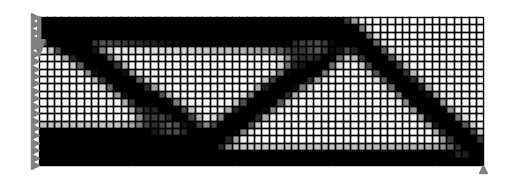

In [5]:
model.plot(element_property=rho[-1], cmap="gray_r")